# Exploratory Data Analysis

Let's play!

In [92]:
# Install additional packages
!python -m pip install seaborn
!python -m pip install xgboost
!python -m pip install m2cgen
!python -m pip install treelite
!python -m pip install treelite_runtime
!python -m pip install tl2cgen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.8/774.8 kB 3.6 MB/s eta 0:00:00a 0:00:01


In [93]:
import os

import keras
import matplotlib.pyplot as plt
import m2cgen as m2c
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import treelite
import treelite_runtime
import tl2cgen
from xgboost import XGBClassifier, XGBRegressor

In [3]:
# Settings
DATA_PATH = "data/sg92r/force"
SEED = 42
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2
NO_FORCE_PREFIX = "0mm"
MAX_POT = 3.3
MODEL_PATH = "models/sg92r"
SERVO_STATE_FREE = 0
SERVO_STATE_CONTACT = 1
SERVO_STATE_STALL = 2

## Initial Exploration (Correlation)

In [4]:
# Get files in the data directory
csv_files = os.listdir(DATA_PATH)

# Shuffle list of files
rng = np.random.default_rng(seed=SEED)
rng.shuffle(csv_files)

# Split files into train, validation, and test sets
num_files = len(csv_files)
num_val_files = int(num_files * VAL_SPLIT)
num_test_files = int(num_files * TEST_SPLIT)
val_files = csv_files[:num_val_files]
test_files = csv_files[num_val_files:num_val_files + num_test_files]
train_files = csv_files[num_val_files + num_test_files:]

# Print split information
print(f"Total files: {num_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Total files: 2400
Train files: 1440
Validation files: 480
Test files: 480


In [5]:
# Load data
def load_csv_files(files):
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(os.path.join(DATA_PATH, file)))
    return pd.concat(df_list, ignore_index=True)

# Build dataframes
df_train = load_csv_files(train_files)
df_val = load_csv_files(val_files)
df_test = load_csv_files(test_files)

# Remove leading and trailing whitespaces from column names
df_train.columns = df_train.columns.str.strip()
df_val.columns = df_val.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Get columns from dataframe
columns = df_train.columns
print(columns)

Index(['Timestamp', 'Desired Position', 'Servo Current', 'Servo Voltage',
       'Servo Potentiometer', 'Encoder', 'Force'],
      dtype='object')


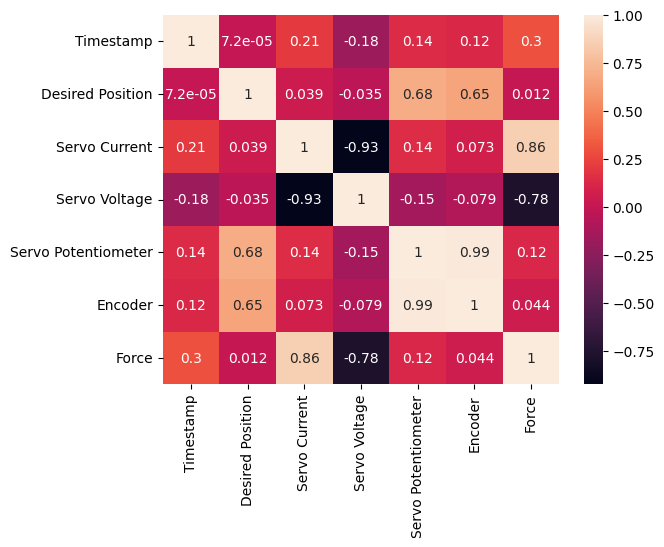

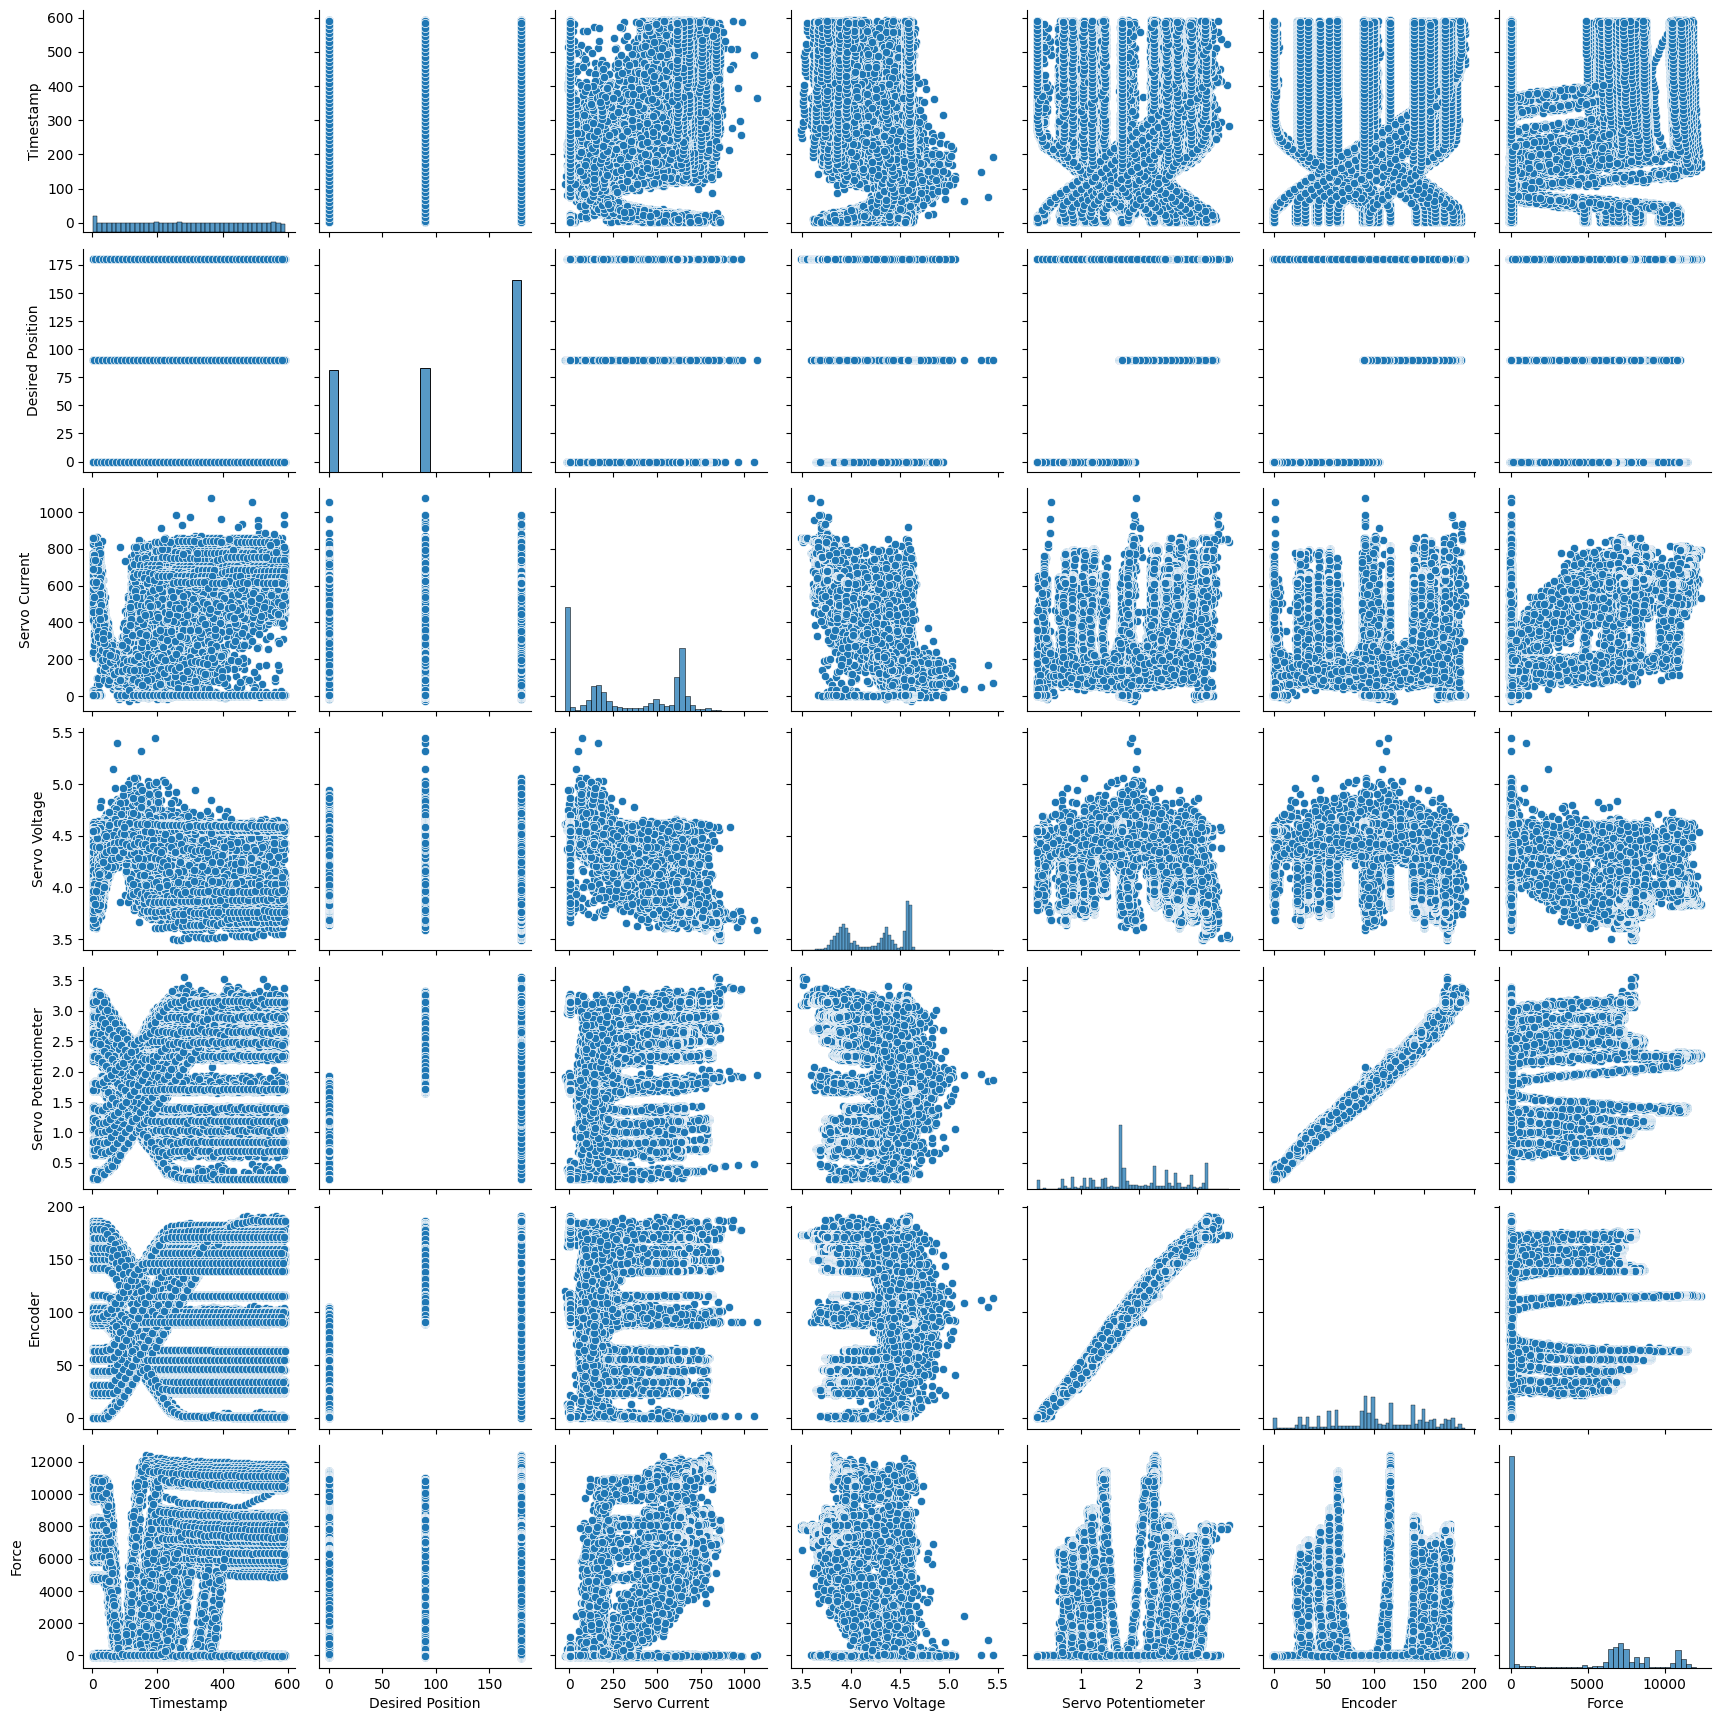

In [6]:
# Create correlation plots
sns.heatmap(df_train[columns].corr(), annot=True)
sns.pairplot(df_train[columns])

In [7]:
# Clone dataframes
df_pos_train = df_train.copy()
df_pos_val = df_val.copy()
df_pos_test = df_test.copy()

# Create a column that is delta timestamp
df_pos_train['delta_time'] = df_train['Timestamp'].diff()
df_pos_val['delta_time'] = df_val['Timestamp'].diff()
df_pos_test['delta_time'] = df_test['Timestamp'].diff()

# Drop rows with NaN values
df_pos_train.dropna(inplace=True)
df_pos_val.dropna(inplace=True)
df_pos_test.dropna(inplace=True)

# Drop timestamp, desired position, and servo voltage columns
df_pos_train.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_val.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_test.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)

# Get new columns from dataframe
columns = df_pos_train.columns
print(columns)

Index(['Servo Current', 'Servo Potentiometer', 'Encoder', 'Force',
       'delta_time'],
      dtype='object')


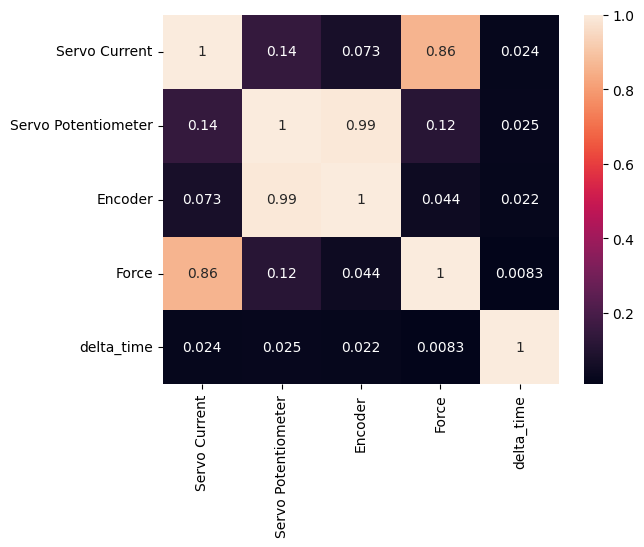

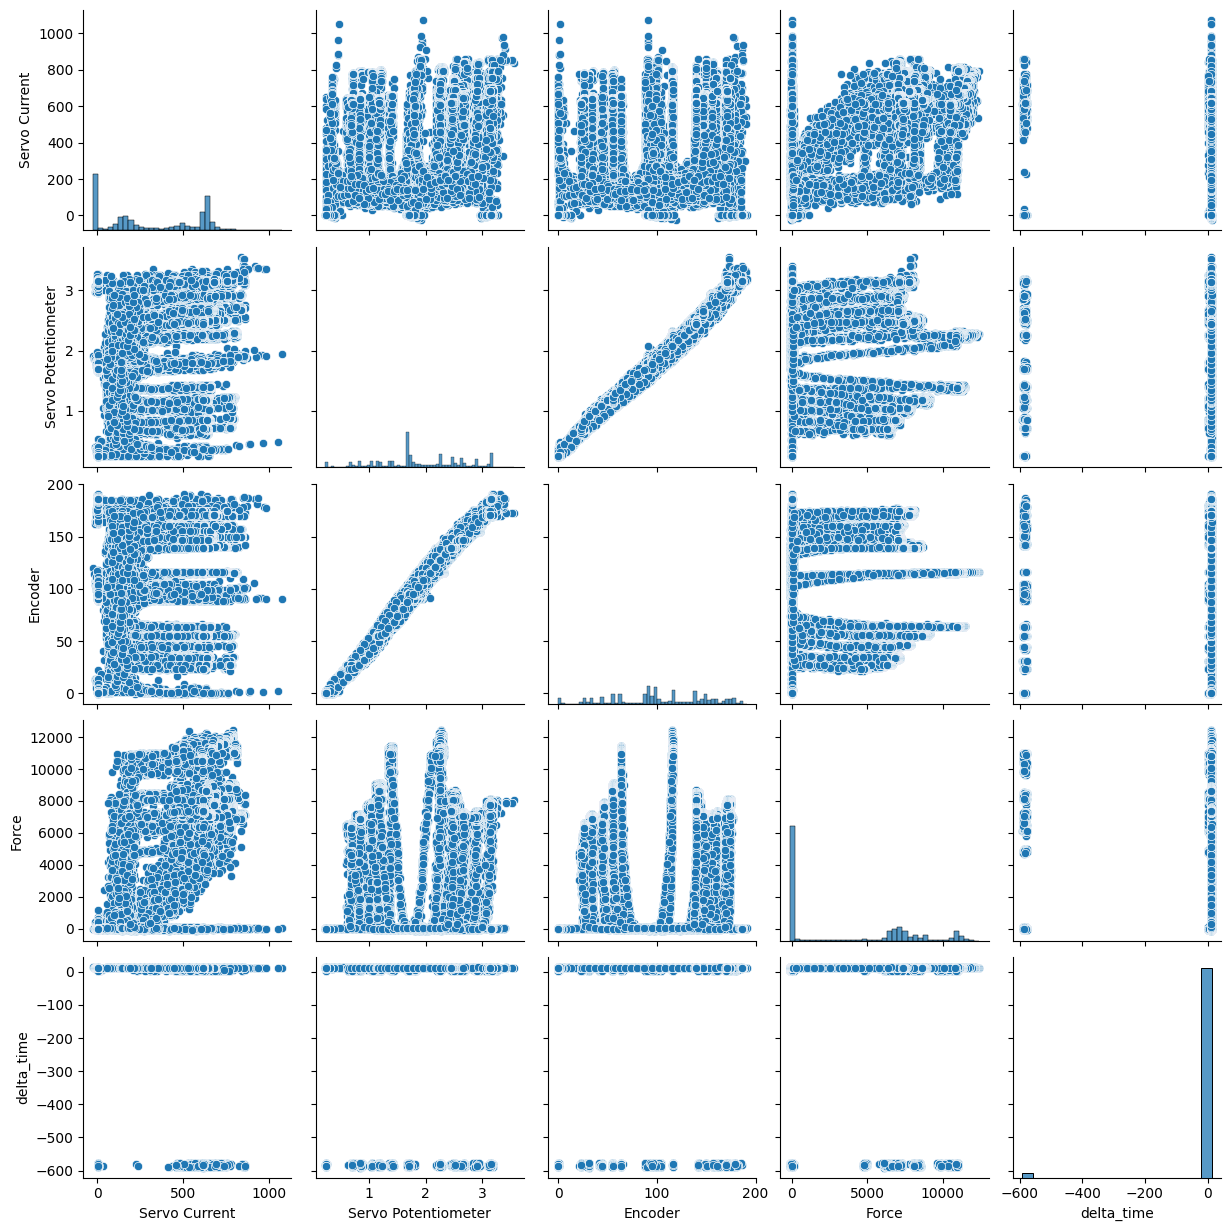

In [8]:
# Create correlation plots
sns.heatmap(df_pos_train[columns].corr(), annot=True)
sns.pairplot(df_pos_train[columns])


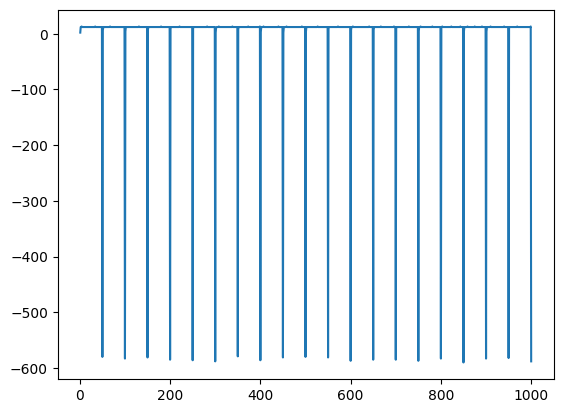

In [9]:
# Plot delta time over time (heads up: includes space between files)
plt.plot(df_pos_train['delta_time'][0:1000])

## Try Linear Regression Model for Position Estimation

In [10]:
# Train model
X_train = df_train[['Servo Potentiometer']]
y_train = df_train['Encoder']
model = LinearRegression()
model.fit(X_train, y_train)

# Validate model
X_val = df_val[['Servo Potentiometer']]
y_val = df_val['Encoder']
y_val_pred = model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean squared error (val): {mse}")

Mean squared error (val): 36.76752051016707


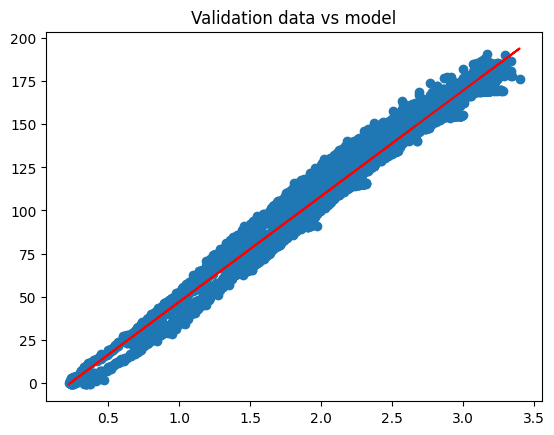

In [11]:
# Plot line vs actual values
plt.scatter(X_val, y_val)
plt.plot(X_val, y_val_pred, color='red')
plt.title('Validation data vs model')
plt.show()

## Stall Estimation Exploration

In [12]:
# Plot positional differences
def plot_pos_diffs(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of position differences
    dpos_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        dpos = abs(df['Desired Position'] - df['Encoder'])
        dpos_list.append(dpos)

    # Plot position differences with legend
    for dpos in dpos_list:
        plt.plot(dpos)
    plt.legend(files)

In [13]:
# Plot servo current over time
def plot_current(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of servo currents
    current_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        current = df['Servo Current']
        current_list.append(current)

    # Plot servo current with legend
    for current in current_list:
        plt.plot(current)
    plt.legend(files)

In [14]:
# Plot voltage over time
def plot_voltage(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of servo voltages
    voltage_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        voltage = df['Servo Voltage']
        voltage_list.append(voltage)

    # Plot servo voltage with legend
    for voltage in voltage_list:
        plt.plot(voltage)
    plt.legend(files)

In [15]:
# Plot force
def plot_force(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of forces
    force_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        force = df['Force']
        force_list.append(force)

    # Plot force with legend
    for force in force_list:
        plt.plot(force)
    plt.legend(files)

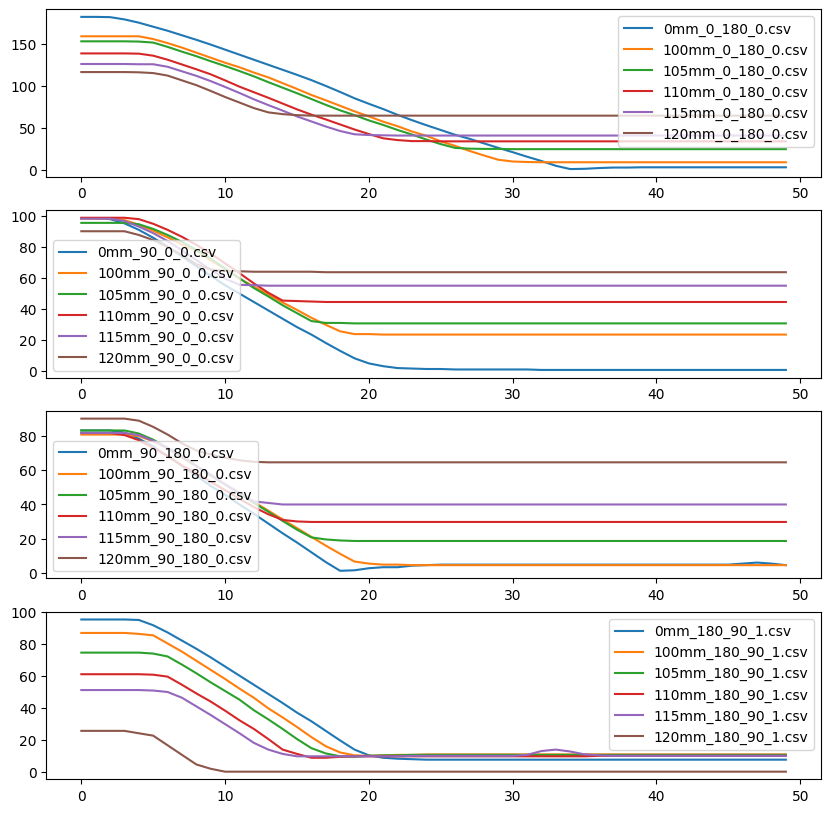

In [16]:
# List of files to test
file_lists = [[
      '0mm_0_180_0.csv',
    '100mm_0_180_0.csv',
    '105mm_0_180_0.csv',
    '110mm_0_180_0.csv',
    '115mm_0_180_0.csv',
    '120mm_0_180_0.csv',
],
[
      '0mm_90_0_0.csv',
    '100mm_90_0_0.csv',
    '105mm_90_0_0.csv',
    '110mm_90_0_0.csv',
    '115mm_90_0_0.csv',
    '120mm_90_0_0.csv',
],
[
      '0mm_90_180_0.csv',
    '100mm_90_180_0.csv',
    '105mm_90_180_0.csv',
    '110mm_90_180_0.csv',
    '115mm_90_180_0.csv',
    '120mm_90_180_0.csv',
],
[
      '0mm_180_90_1.csv',
    '100mm_180_90_1.csv',
    '105mm_180_90_1.csv',
    '110mm_180_90_1.csv',
    '115mm_180_90_1.csv',
    '120mm_180_90_1.csv',
]]

# Plot positional differences on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_pos_diffs(file_list)

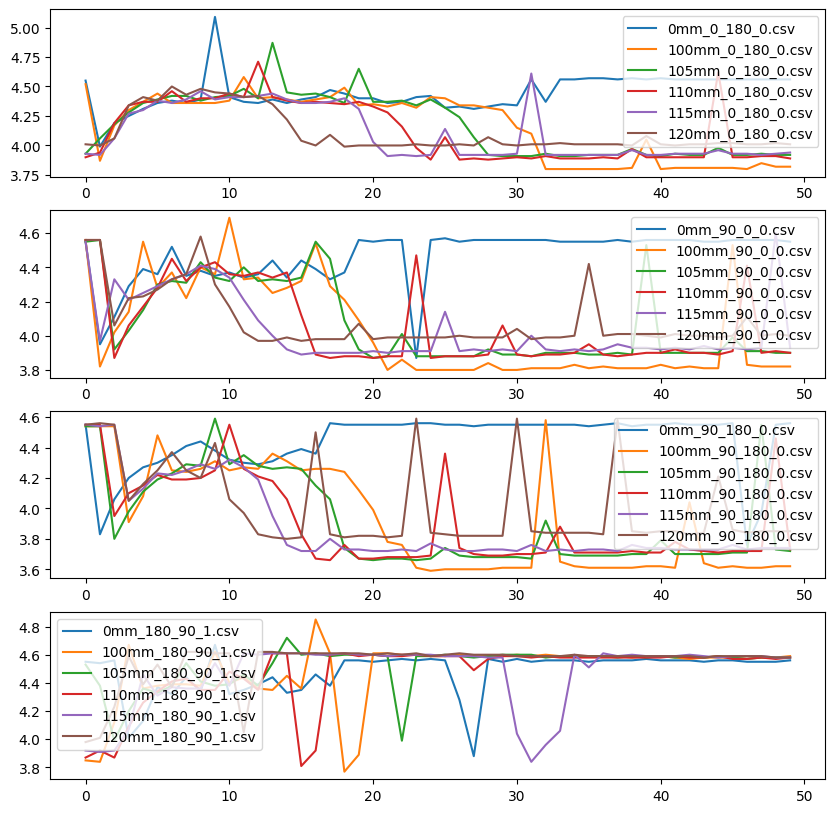

In [17]:
# Plot voltage on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_voltage(file_list)

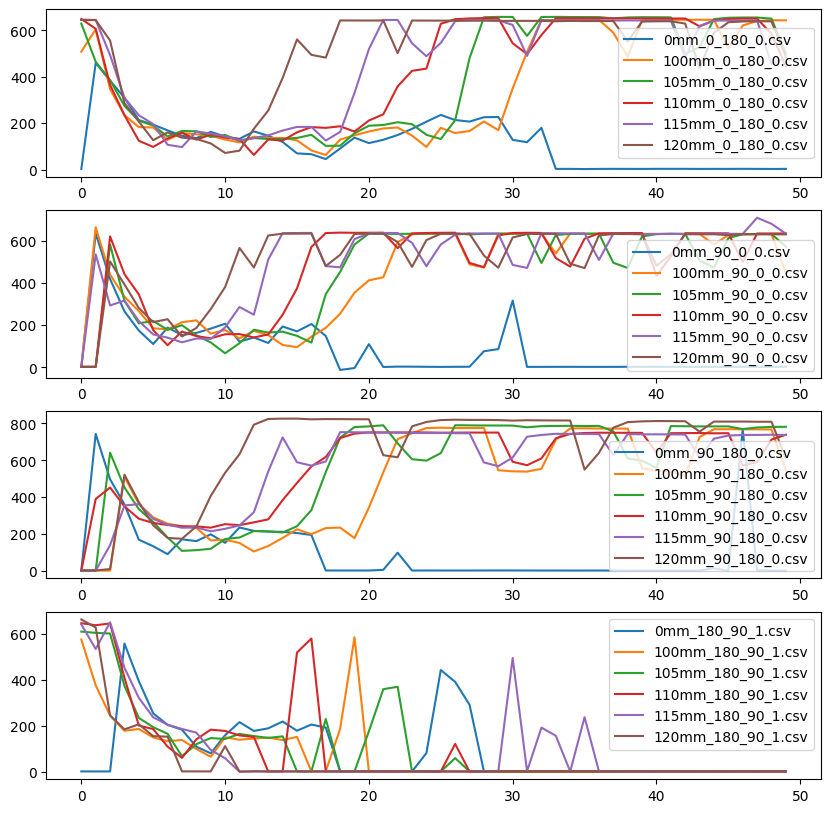

In [18]:
# Plot current on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_current(file_list)

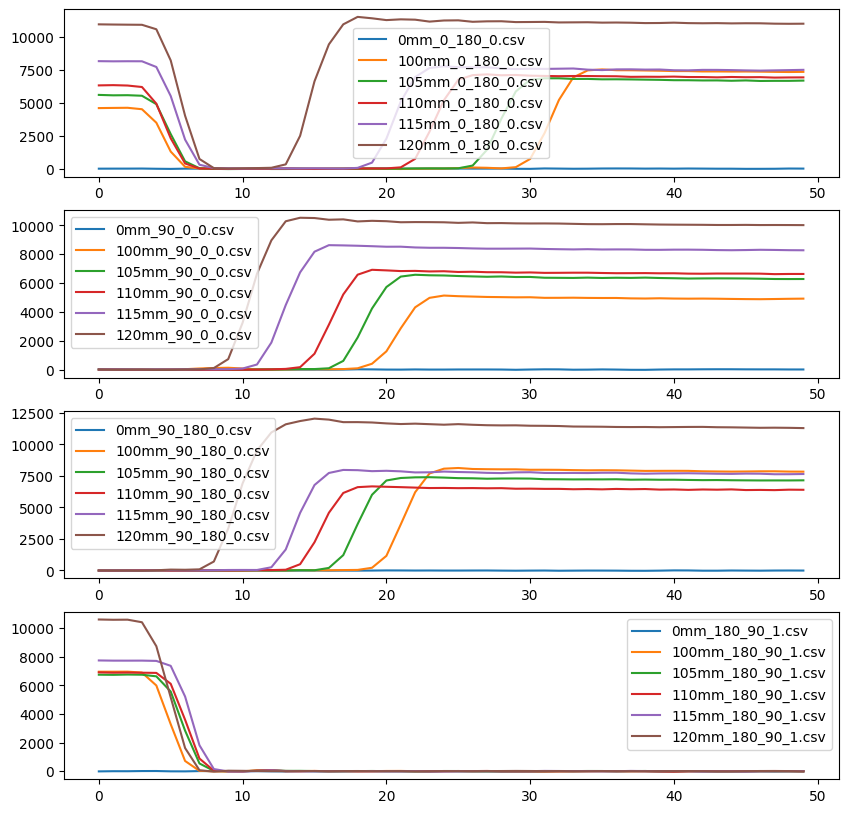

In [19]:
# Plot force on subplots
# Plot on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_force(file_list)

In [20]:
# Normalize
def normalize(val):
    return (val - val.min()) / (val.max() - val.min())

In [21]:
# Plot normalized force
def plot_normalized_force(files):
    
    # List of forces
    force_list = []

    # Read in data from files
    for file in files:

        # Read force column
        df = pd.read_csv(os.path.join(DATA_PATH, file))
        df.columns = df.columns.str.strip()
        force = normalize(df['Force'])

        # If file prefix is 0mm, set force to 0
        if file.startswith('0mm'):
            force = np.zeros(len(force))

        # Append force to list
        force_list.append(force)

    # Normalize forces
    for force in force_list:
        plt.plot(force)
    plt.legend(files)

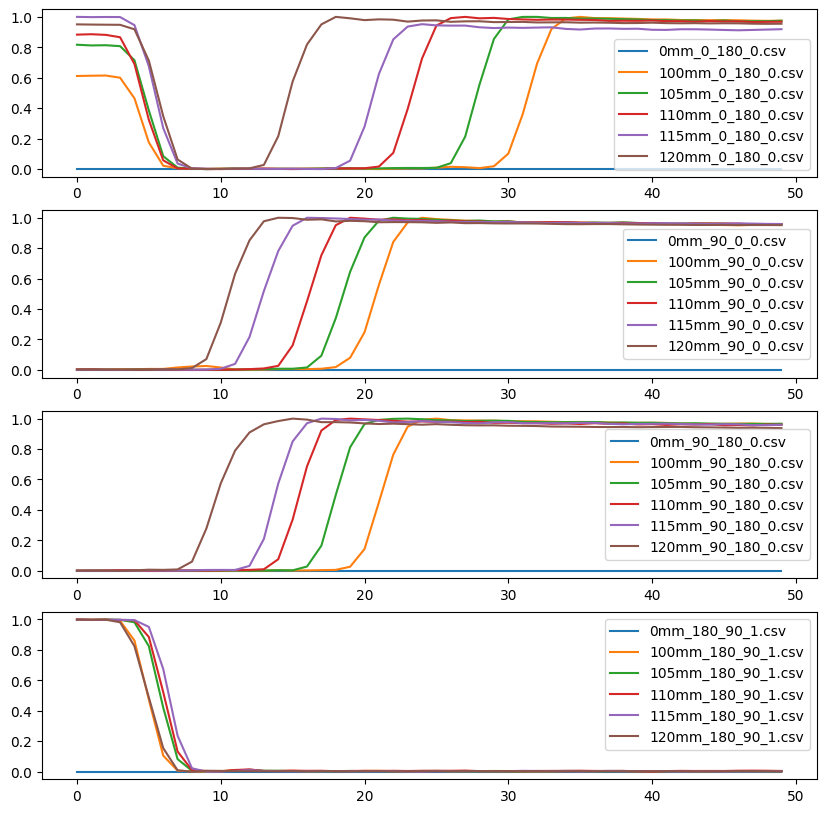

In [22]:
# Plot normalized force on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_normalized_force(file_list)

## Create Dataset

In [23]:
# Get files in the data directory
csv_files = os.listdir(DATA_PATH)

# Shuffle list of files
rng = np.random.default_rng(seed=SEED)
rng.shuffle(csv_files)

# Split files into train, validation, and test sets
num_files = len(csv_files)
num_val_files = int(num_files * VAL_SPLIT)
num_test_files = int(num_files * TEST_SPLIT)
val_files = csv_files[:num_val_files]
test_files = csv_files[num_val_files:num_val_files + num_test_files]
train_files = csv_files[num_val_files + num_test_files:]

# Print split information
print(f"Total files: {num_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Total files: 2400
Train files: 1440
Validation files: 480
Test files: 480


In [24]:
# Load data and modify dataframes
def load_and_modify_data(files):

    # Create list of dataframes from CSV files
    df_list = []
    for file in files:

        # Read CSV file and strip column names
        df = pd.read_csv(os.path.join(DATA_PATH, file))
        df.columns = df.columns.str.strip()

        # Create a "stall" column
        force = normalize(df['Force'])
        if file.startswith(NO_FORCE_PREFIX):
            force = np.zeros(len(force))
        df['Stall'] = force

        # Create a categorized servo state based on the stall value
        state_conditions = [
            df['Stall'] <= 0.1,
            (df['Stall'] > 0.1) & (df['Stall'] <= 0.8),
            df['Stall'] > 0.8
        ]
        state_choices = [SERVO_STATE_FREE, SERVO_STATE_CONTACT, SERVO_STATE_STALL]
        df['Servo State'] = np.select(state_conditions, state_choices)
        
        # Creata a "delta time" column (seconds)
        df['Delta Time'] = df['Timestamp'].diff() / 1000

        # Normalize the potentiometer readings
        df['Norm Potentiometer'] = df['Servo Potentiometer'] / MAX_POT

        # Create a "position derivative" column
        df['Derivative Potentiometer'] = df['Norm Potentiometer'].diff() / df['Delta Time']

        # Create a "current derivative" column
        df['Derivative Current'] = df['Servo Current'].diff() / df['Delta Time']

        # Create sin and cos columns (1.0 = 180 degrees)
        df['Sin Potentiometer'] = np.sin(df['Norm Potentiometer'] * np.pi)
        df['Cos Potentiometer'] = np.cos(df['Norm Potentiometer'] * np.pi)

        # Create multiplication columns
        df['Current * Potentiometer'] = df['Servo Current'] * df['Norm Potentiometer']

        # Clean up the dataframe (drop NaN values and columns)
        df.dropna(inplace=True)

        # Drop columns
        df.drop(columns=[
            'Timestamp', 
            'Servo Voltage', 
            'Encoder', 
            'Force', 
            'Servo Potentiometer'
        ], inplace=True)
        
        # Append dataframe to list
        df_list.append(df)

    return pd.concat(df_list, ignore_index=True)

In [25]:
# Build dataframes (and randomize row orders)
df_train = load_and_modify_data(train_files).sample(frac=1)
df_val = load_and_modify_data(val_files).sample(frac=1)
df_test = load_and_modify_data(test_files).sample(frac=1)

# Get column names from dataframe
columns = df_train.columns
print(columns)

Index(['Desired Position', 'Servo Current', 'Stall', 'Servo State',
       'Delta Time', 'Norm Potentiometer', 'Derivative Potentiometer',
       'Derivative Current', 'Sin Potentiometer', 'Cos Potentiometer',
       'Current * Potentiometer'],
      dtype='object')


In [26]:
df_train.head()

Desired Position  Servo Current     Stall  Servo State  Delta Time  \
5888              180.0          161.4  0.002394            0       0.012   
49190             180.0          558.6  0.958347            2       0.012   
13447             180.0          678.1  0.996358            2       0.012   
12739              90.0            3.1  0.001593            0       0.012   
28693              90.0            3.2  0.001766            0       0.012   

       Norm Potentiometer  Derivative Potentiometer  Derivative Current  \
5888             0.409091                  2.272727         -583.333333   
49190            0.684848                  0.000000        -4958.333333   
13447            0.951515                  0.505051          116.666667   
12739            0.515152                  0.000000            8.333333   
28693            0.512121                 -0.252525           33.333333   

       Sin Potentiometer  Cos Potentiometer  Current * Potentiometer  
5888            0.959493           0.281733                66.027273  
49190           0.836069          -0.548625               382.556364  
13447           0.151731          -0.988422               645.222424  
12739           0.998867          -0.047582                 1.596970  
28693           0.999275          -0.038071                 1.638788

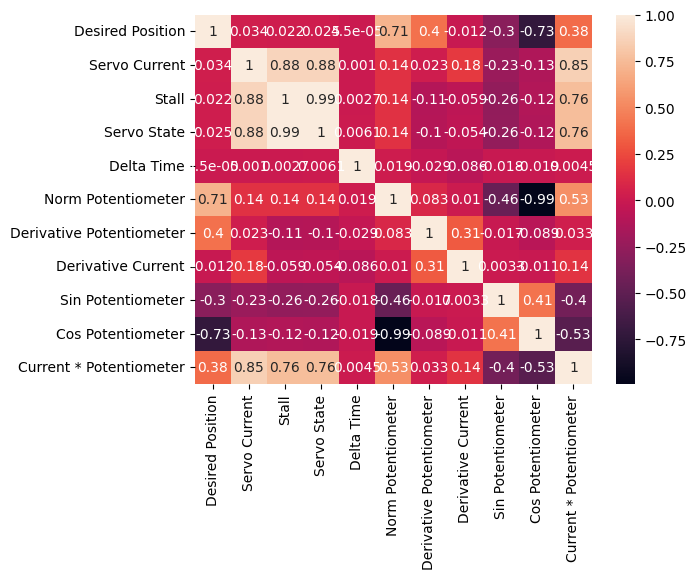

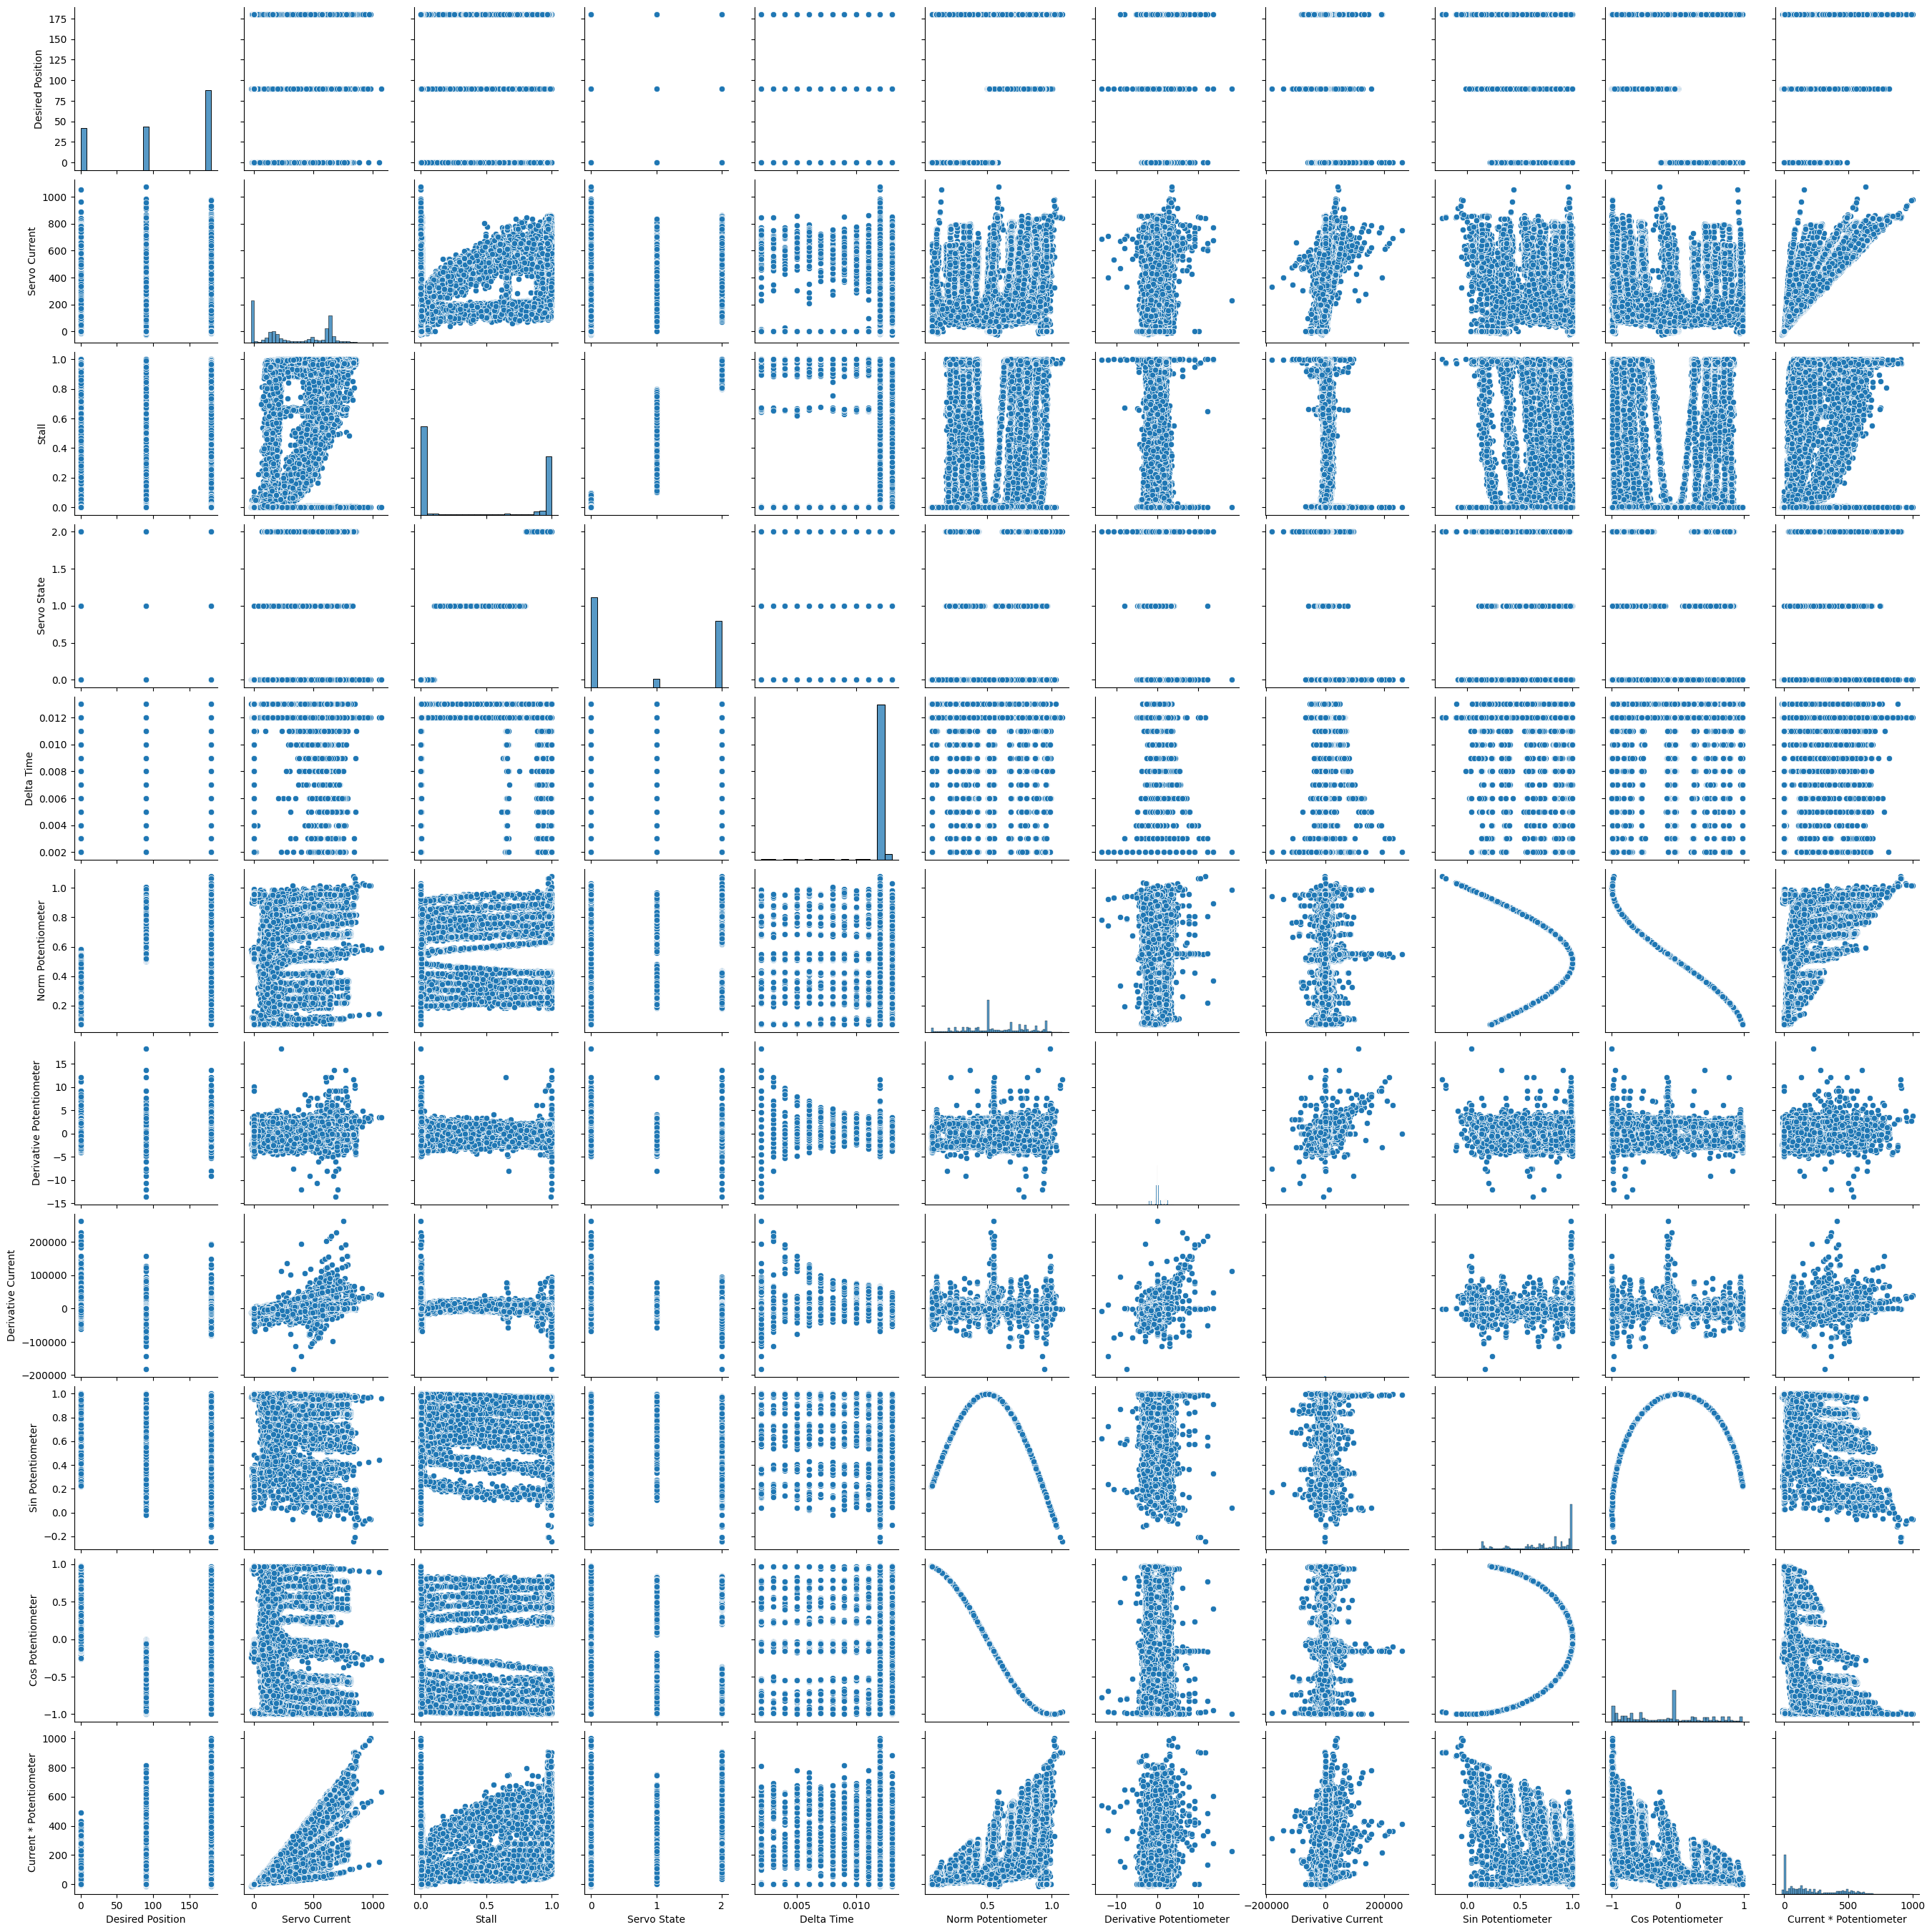

In [27]:
# Create correlation plots
sns.heatmap(df_train[columns].corr(), annot=True)
sns.pairplot(df_train[columns])

In [28]:
# X and y columns
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    'Derivative Current',
    'Sin Potentiometer',
]
y_cols = ['Stall']

# Create X dataframes
X_train = df_train[X_cols]
X_val = df_val[X_cols]
X_test = df_test[X_cols]

# Create y dataframes
y_train = df_train[y_cols]
y_val = df_val[y_cols]
y_test = df_test[y_cols]

## Model Exploration: Linear Regression

In [29]:
# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)
score_train = model.score(X_train, y_train)
print(f"Score (train): {score_train}")
print(model.coef_)
print(model.intercept_)

Score (train): 0.8305490622735155
[[ 1.57609054e-03 -3.84635290e-02 -1.04535588e-05 -1.04018860e-01]]
[0.0110586]


In [30]:
# Validate model and calculate mean squared error
score = model.score(X_val, y_val)
y_val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")


Score (val): 0.8269429321395099
Mean squared error (val): 0.03838702043162875


## Model Exploration: DNN

In [31]:
# Set default devcice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Create simple neural network
inputs = keras.Input(shape=(len(X_cols),))
x1 = keras.layers.Dense(16, activation="relu")(inputs)
x2 = keras.layers.Dense(8, activation="relu")(x1)
output = keras.layers.Dense(1)(x2)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Copy data to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

In [34]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=10, 
    batch_size=128
)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 518490.6875 - val_loss: 164.5490
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 91.2544 - val_loss: 40.6404
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 32.9088 - val_loss: 23.0880
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 18.5476 - val_loss: 11.2738
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.5943 - val_loss: 6.4566
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.5374 - val_loss: 3.6679
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.8189 - val_loss: 4.9875
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.3115 - val_loss: 2.4446
Epoch 9/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8768 - val_loss: 3.8267
Epoch 10/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7.1410 - val_loss: 179.0460


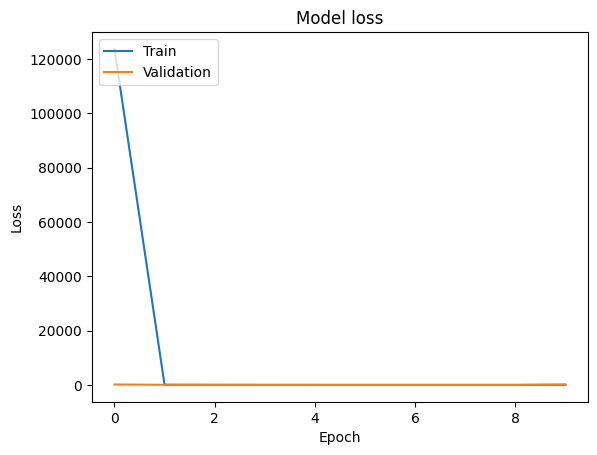

In [35]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Time Windowing

In [36]:
# Settings
READINGS_PER_SAMPLE = 3

In [37]:
# Build dataframes
df_train = load_and_modify_data(train_files)
df_val = load_and_modify_data(val_files)
df_test = load_and_modify_data(test_files)

# Get column names from dataframe
columns = df_train.columns
print(columns)

Index(['Desired Position', 'Servo Current', 'Stall', 'Servo State',
       'Delta Time', 'Norm Potentiometer', 'Derivative Potentiometer',
       'Derivative Current', 'Sin Potentiometer', 'Cos Potentiometer',
       'Current * Potentiometer'],
      dtype='object')


In [38]:
# Create windowed dataframes
def create_windowed_data(df, readings_per_sample):

    # Create a list of dataframes
    df_list = []

    # Create a windowed dataframe
    for i in range(len(df) - readings_per_sample):
        df_window = df[i:i + readings_per_sample].copy()
        df_window.reset_index(drop=True, inplace=True)
        df_list.append(df_window)

    return pd.concat(df_list, ignore_index=True)

In [39]:
# Create windowed dataframes
df_train_windowed = create_windowed_data(df_train, READINGS_PER_SAMPLE)
df_val_windowed = create_windowed_data(df_val, READINGS_PER_SAMPLE)
df_test_windowed = create_windowed_data(df_test, READINGS_PER_SAMPLE)

# Print length of windowed dataframes
print(len(df_train_windowed))

211671


In [40]:
df_train_windowed.head(20)

Desired Position  Servo Current  Stall  Servo State  Delta Time  \
0               90.0            3.0    0.0            0       0.002   
1               90.0          632.2    0.0            0       0.012   
2               90.0          409.5    0.0            0       0.012   
3               90.0          632.2    0.0            0       0.012   
4               90.0          409.5    0.0            0       0.012   
5               90.0          292.2    0.0            0       0.013   
6               90.0          409.5    0.0            0       0.012   
7               90.0          292.2    0.0            0       0.013   
8               90.0          215.0    0.0            0       0.012   
9               90.0          292.2    0.0            0       0.013   
10              90.0          215.0    0.0            0       0.012   
11              90.0          132.9    0.0            0       0.012   
12              90.0          215.0    0.0            0       0.012   
13              90.0          132.9    0.0            0       0.012   
14              90.0          139.9    0.0            0       0.012   
15              90.0          132.9    0.0            0       0.012   
16              90.0          139.9    0.0            0       0.012   
17              90.0          186.9    0.0            0       0.012   
18              90.0          139.9    0.0            0       0.012   
19              90.0          186.9    0.0            0       0.012   

    Norm Potentiometer  Derivative Potentiometer  Derivative Current  \
0             0.954545                  0.000000         -150.000000   
1             0.990909                  3.030303        52433.333333   
2             0.957576                 -2.777778       -18558.333333   
3             0.990909                  3.030303        52433.333333   
4             0.957576                 -2.777778       -18558.333333   
5             0.924242                 -2.564103        -9023.076923   
6             0.957576                 -2.777778       -18558.333333   
7             0.924242                 -2.564103        -9023.076923   
8             0.887879                 -3.030303        -6433.333333   
9             0.924242                 -2.564103        -9023.076923   
10            0.887879                 -3.030303        -6433.333333   
11            0.857576                 -2.525253        -6841.666667   
12            0.887879                 -3.030303        -6433.333333   
13            0.857576                 -2.525253        -6841.666667   
14            0.833333                 -2.020202          583.333333   
15            0.857576                 -2.525253        -6841.666667   
16            0.833333                 -2.020202          583.333333   
17            0.812121                 -1.767677         3916.666667   
18            0.833333                 -2.020202          583.333333   
19            0.812121                 -1.767677         3916.666667   

    Sin Potentiometer  Cos Potentiometer  Current * Potentiometer  
0            0.142315          -0.989821                 2.863636  
1            0.028556          -0.999592               626.452727  
2            0.132885          -0.991131               392.127273  
3            0.028556          -0.999592               626.452727  
4            0.132885          -0.991131               392.127273  
5            0.235759          -0.971812               270.063636  
6            0.132885          -0.991131               392.127273  
7            0.235759          -0.971812               270.063636  
8            0.345000          -0.938603               190.893939  
9            0.235759          -0.971812               270.063636  
10           0.345000          -0.938603               190.893939  
11           0.432658          -0.901558               113.971818  
12           0.345000          -0.938603               190.893939  
13           0.432658          -0.901558       

In [41]:
# Convert dataframes to 3D tensors and ground-truth tensors
def df_to_tensor(df, readings_per_sample, X_cols, y_cols):

    # Get number of samples
    num_samples = len(df) // readings_per_sample

    # y is the final reading in each sample
    y = df[y_cols].iloc[readings_per_sample - 1::readings_per_sample].values
    y = torch.tensor(y, dtype=torch.float32)

    # Create 3D tensor
    X = torch.zeros((num_samples, readings_per_sample, len(X_cols)))

    # Fill tensor (only with X columns)
    for i in range(num_samples):
        X[i] = torch.tensor(df[X_cols].iloc[(i * readings_per_sample):((i + 1) * readings_per_sample)].values, dtype=torch.float32)

    return X, y

## Classification

In [42]:
# Choose X and y columns
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    # 'Derivative Potentiometer',
    # 'Derivative Current',
    # 'Sin Potentiometer',
    # 'Cos Potentiometer',
    # 'Current * Potentiometer',
]
y_cols = ['Servo State']

# Convert dataframes to 3D tensors
X_train, y_train = df_to_tensor(df_train_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_val, y_val = df_to_tensor(df_val_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_test, y_test = df_to_tensor(df_test_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)

# Zip data
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))
test_data = list(zip(X_test, y_test))

# Shuffle data
rng.shuffle(train_data)
rng.shuffle(val_data)
rng.shuffle(test_data)

# Unzip data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to tensors
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)
X_val = torch.stack(X_val)
y_val = torch.stack(y_val)
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

# Show shape
print(X_train.shape)

torch.Size([70557, 3, 2])


In [43]:
# Make sure the tensor is correct (no longer matches dataframe after shuffle)
# i = 10507
# df_train_windowed.iloc[(i * READINGS_PER_SAMPLE):((i + 1) * READINGS_PER_SAMPLE)]

In [44]:
# print(X_train[i, :, :])
# print(y_train[i])

In [45]:
# Copy data to device (for training)
X_train_tensor = X_train.to(device)
y_train_tensor = y_train.to(device)
X_val_tensor = X_val.to(device)
y_val_tensor = y_val.to(device)

### Model Exploration: Random Forest (Windowed)

In [46]:
# Train random forest classifier
rf = RandomForestClassifier(
    n_estimators=18,
    max_depth=5,
    random_state=SEED
)
rf.fit(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
score_train = rf.score(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = rf.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
rf_serialized = pickle.dumps(rf)
print(f"Size of model: {len(rf_serialized) / 1024} kB")

Accuracy (train): 0.9661125047833666
Accuracy (val): 0.9650890844920695
Size of model: 95.890625 kB


### Model Exploration: XGBoost (Windowed)

In [47]:
# Train XGBoost classifier
xgb = XGBClassifier(
    n_estimators=18,
    max_depth=5,
    random_state=SEED
)
score_train = xgb.fit(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
score_train = xgb.score(X_train.cpu().numpy().reshape(X_train.shape[0], -1), y_train.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = xgb.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
xgb_serialized = pickle.dumps(xgb)
print(f"Size of model: {len(xgb_serialized) / 1024} kB")

Accuracy (train): 0.9842963844834672
Accuracy (val): 0.9820555342943402
Size of model: 131.6689453125 kB


### Model Exploration: SVM (Windowed)

In [51]:
# Get a random subset of data to make training faster
subset = 3000
X_train_subset = X_train[:subset]
y_train_subset = y_train[:subset]

In [52]:
# Create SVM classifier
svm = SVC(
    kernel='linear',
    C=0.1,
    random_state=SEED
)
svm.fit(X_train_subset.cpu().numpy().reshape(X_train_subset.shape[0], -1), y_train_subset.cpu().numpy().ravel())
score_train = svm.score(X_train_subset.cpu().numpy().reshape(X_train_subset.shape[0], -1), y_train_subset.cpu().numpy().ravel())
print(f"Accuracy (train): {score_train}")

# Print validation accuracy
score_val = svm.score(X_val.cpu().numpy().reshape(X_val.shape[0], -1), y_val.cpu().numpy().ravel())
print(f"Accuracy (val): {score_val}")

# Print size of model
svm_serialized = pickle.dumps(svm)
print(f"Size of model: {len(svm_serialized) / 1024} kB")

Accuracy (train): 0.9198
Accuracy (val): 0.9181017986988136
Size of model: 105.9521484375 kB


### Model Exploration: 1D CNN (Windowed)

In [53]:
# Create 1D CNN
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Conv1D(8, 2, activation="relu")(inputs)
# x = keras.layers.MaxPooling1D(2, strides=1, padding="same")(x)
x = keras.layers.Conv1D(8, 2, activation="relu")(x)
# x = keras.layers.MaxPooling1D(2, strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.25)(x)
# x = keras.layers.Dense(16, activation="relu")(x)
output = keras.layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.to(device)
print(model.summary())

# Print the size of the model in kilobytes
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024
print(f"Size of model: {model_size} kB")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203 (812.00 B)

 Trainable params: 203 (812.00 B)

 Non-trainable params: 0 (0.00 B)

None
Size of model: 0.79296875 kB


In [54]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=30, 
    batch_size=128
)

Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6837 - loss: 2.2774 - val_accuracy: 0.8949 - val_loss: 0.4013
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9175 - loss: 0.3924 - val_accuracy: 0.9320 - val_loss: 0.2916
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9324 - loss: 0.2918 - val_accuracy: 0.9334 - val_loss: 0.2667
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9388 - loss: 0.2600 - val_accuracy: 0.9389 - val_loss: 0.2427
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9408 - loss: 0.2406 - val_accuracy: 0.9356 - val_loss: 0.2529
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9395 - loss: 0.2461 - val_accuracy: 0.9335 - val_loss: 0.2532
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9422 - loss: 0.2325 - val_accuracy: 0.9395 - val_loss: 0.2318
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9402 - loss: 0.2426 - val_accu

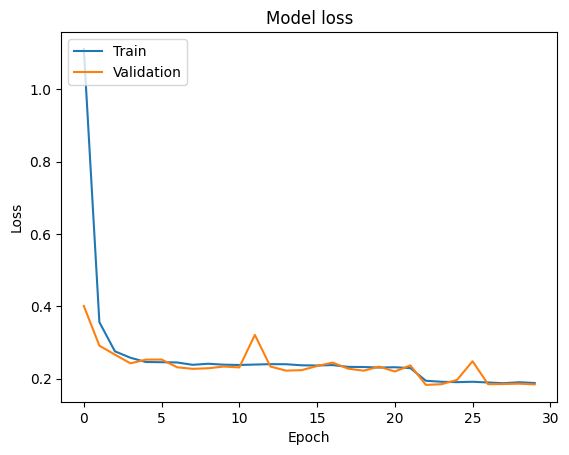

In [55]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][-50:])
plt.plot(history.history['val_loss'][-50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
# Test model accuracy on validation set
score_val = model.evaluate(X_val_tensor, y_val_tensor, verbose=0)
print(f"Accuracy (val): {score_val[1]}")

Accuracy (val): 0.9438703656196594


## Regression

In [42]:
# X and y columns
# X_cols = [
#     'Servo Current',
#     'Norm Potentiometer',
#     'Sin Potentiometer',
# ]
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    # 'Derivative Potentiometer',
    # 'Derivative Current',
    # 'Sin Potentiometer',
    # 'Cos Potentiometer',
    # 'Current * Potentiometer',
]
y_cols = ['Stall']

# Convert dataframes to 3D tensors
X_train, y_train = df_to_tensor(df_train_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_val, y_val = df_to_tensor(df_val_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_test, y_test = df_to_tensor(df_test_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)

# Zip data
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))
test_data = list(zip(X_test, y_test))

# Shuffle data
rng.shuffle(train_data)
rng.shuffle(val_data)
rng.shuffle(test_data)

# Unzip data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to tensors
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)
X_val = torch.stack(X_val)
y_val = torch.stack(y_val)
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

# Show shape
print(X_train.shape)

torch.Size([70557, 3, 2])


In [43]:
# Make sure the tensor is correct (not working after shuffle)
# i = 10507
# df_train_windowed.iloc[(i * READINGS_PER_SAMPLE):((i + 1) * READINGS_PER_SAMPLE)]

In [44]:
# print(X_train[i, :, :])
# print(y_train[i])

In [45]:
# Copy data to device (for training)
X_train_tensor = X_train.to(device)
y_train_tensor = y_train.to(device)
X_val_tensor = X_val.to(device)
y_val_tensor = y_val.to(device)

### Model Exploration: Linear Regression (Windowed)

In [46]:
# Flatten the readings for linear regression
X_train_flat =X_train_tensor.view(X_train_tensor.size(0), -1)
y_train_flat = y_train_tensor.view(-1, 1)
X_val_flat = X_val_tensor.view(X_val_tensor.size(0), -1)
y_val_flat = y_val_tensor.view(-1, 1)

# View shape
print(X_train_flat.shape)
print(X_train_flat[i])
print(y_train_flat[i])

torch.Size([70557, 6])
tensor([215.3000,   0.6121, 210.6000,   0.6394, 177.1000,   0.6667],
       device='cuda:0')
tensor([0.0038], device='cuda:0')


In [47]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
score_train = model.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
print(f"Score (train): {score_train}")
print(model.coef_)
print(model.intercept_)

Score (train): 0.8332395553588867
[[5.3790089e-04 8.0966856e-08 3.6038103e-04 6.3140753e-08 7.4848288e-04
  8.4308539e-08]]
[-0.11407733]


In [48]:
# Validate model and calculate mean squared error
score = model.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy())
y_val_pred = model.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.829115629196167
Mean squared error (val): 0.03790366277098656


### Model Exploration: Random Forest (Windowed)

In [49]:
# Train random forest regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=SEED
)
rf.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = rf.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

# Print the size of the model
rf_serialized = pickle.dumps(rf)
print(f"Size of model: {len(rf_serialized) / 1024} kB")

Score (train): 0.984514832168379
Size of model: 6626.0322265625 kB


In [50]:
# Validate model and calculate mean squared error
score = rf.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = rf.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.9784069156659722
Mean squared error (val): 0.004789537759380616


### Model Exploration: XGBoost (Windowed)

In [88]:
# Train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=10,
    max_depth=5,
    random_state=SEED,
    base_score=0.5
)
xgb.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = xgb.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

# Print the size of the model
xgb_serialized = pickle.dumps(xgb)
print(f"Size of model: {len(xgb_serialized) / 1024} kB")

Score (train): 0.9763649106025696
Size of model: 30.708984375 kB


In [89]:
# Validate model and calculate mean squared error
score = xgb.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = xgb.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.9739609956741333
Mean squared error (val): 0.005775677040219307


### Quantize and Save XGBoost Model

In [94]:
# I <3 this model, so let's save it
model_filename = "xgb_model"
xgb.save_model(os.path.join(MODEL_PATH, model_filename + ".json"))

# Convert to C code
with open(os.path.join(MODEL_PATH, ".c"), "w") as f:
    code = m2c.export_to_c(xgb)
    f.write(code)


In [107]:
# Load model into Treelite (NOT WORKING!)
treelite_model = treelite.frontend.load_xgboost_model(
    os.path.join(MODEL_PATH, model_filename + ".json")
)

# Save model to C code
tl2cgen.generate_c_code(
    treelite_model,
    dirpath=os.path.join(MODEL_PATH, "treelite_model"),
    params={
        "quantize": 1,
    },
    verbose=True
)


[00:24:27] /project/src/compiler/ast/split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.


[00:24:27] /tmp/tmpfk5q71dd/libbuild/_deps/treelite-src/src/serializer.cc:202: The model you are loading originated from a newer Treelite version; some functionalities may be unavailable.
Currently running Treelite version 4.1.2
The model checkpoint was generated from Treelite version 4.4.1


In [70]:
# # Get known-good sample
# i = 10507
# X_sample = X_train[i].view(1, -1).to(device)
# y_sample = y_train[i].view(1, 1).to(device)

# # Print sample
# print(X_sample)

# # Perform inference
# y_sample_pred = xgb.predict(X_sample.cpu().numpy())
# print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

In [71]:
# # Do another one (to check for consistency)
# i = 30053
# X_sample = X_train[i].view(1, -1).to(device)
# y_sample = y_train[i].view(1, 1).to(device)

# # Print sample
# print(X_sample)

# # Perform inference
# y_sample_pred = xgb.predict(X_sample.cpu().numpy())
# print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

### Model Exploration: 1D CNN (Windowed)

In [78]:
# Create 1D CNN
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Conv1D(64, 2, activation="relu")(inputs)
# x = keras.layers.MaxPooling1D(2, strides=1, padding="same")(x)
x = keras.layers.Conv1D(64, 2, activation="relu")(x)
# x = keras.layers.MaxPooling1D(2, strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Dense(16, activation="relu")(x)
output = keras.layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error")
model.to(device)
print(model.summary())

# Print the size of the model in kilobytes
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024
print(f"Size of model: {model_size} kB")

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 2, 64)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,633 (37.63 KB)

 Trainable params: 9,633 (37.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Size of model: 37.63671875 kB


In [79]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=20, 
    batch_size=128
)

Epoch 1/20


552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 18.4162 - val_loss: 0.0719
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2533 - val_loss: 0.0454
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1159 - val_loss: 0.0394
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0611 - val_loss: 0.0378
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0459 - val_loss: 0.0316
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0350 - val_loss: 0.0325
Epoch 7/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0315 - val_loss: 0.0391
Epoch 8/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0302 - val_loss: 0.0314
Epoch 9/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0285 - val_loss: 0.0312
Epoch 10/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0288 - val_loss: 0.0262
Epoch 11/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0291 - val_loss: 0.0268
Epoch 12/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0

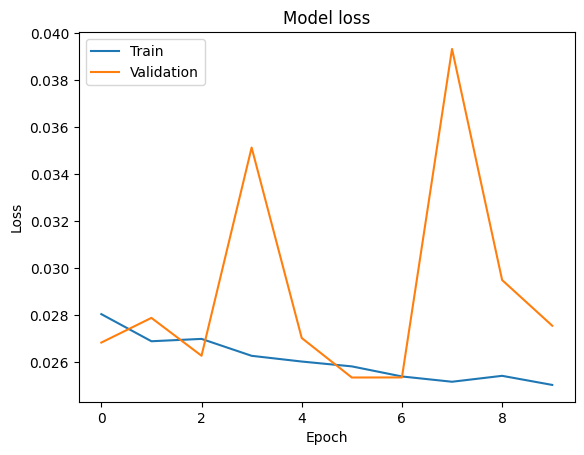

In [80]:
# Plot loss (ignore first epoch)
first_epoch = 10
plt.plot(history.history['loss'][first_epoch:])
plt.plot(history.history['val_loss'][first_epoch:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [81]:
# Test model score on validation set
score_val = model.evaluate(X_val_tensor, y_val_tensor, verbose=0)
print(f"Mean squared error (val): {score_val}")

Mean squared error (val): 0.027557171881198883


## Model Exploration: DNN (Windowed)

In [82]:
# Create simple neural network
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x1 = keras.layers.Flatten()(inputs)
x2 = keras.layers.Dense(32, activation="relu")(x1)
x3 = keras.layers.Dense(32, activation="relu")(x2)
output = keras.layers.Dense(1)(x3)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)
print(model.summary())


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=20, 
    batch_size=128
)

Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 49.7272 - val_loss: 0.2557
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1928 - val_loss: 0.0986
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1005 - val_loss: 0.0666
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1213 - val_loss: 0.0693
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0924 - val_loss: 0.0947
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1281 - val_loss: 0.0909
Epoch 7/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0731 - val_loss: 0.0462
Epoch 8/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1135 - val_loss: 0.1610
Epoch 9/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1046 - val_loss: 0.0696
Epoch 10/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1816 - val_loss: 0.0553
Epoch 11/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0804 - val_loss: 0.0574
Epoch 12/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/ste

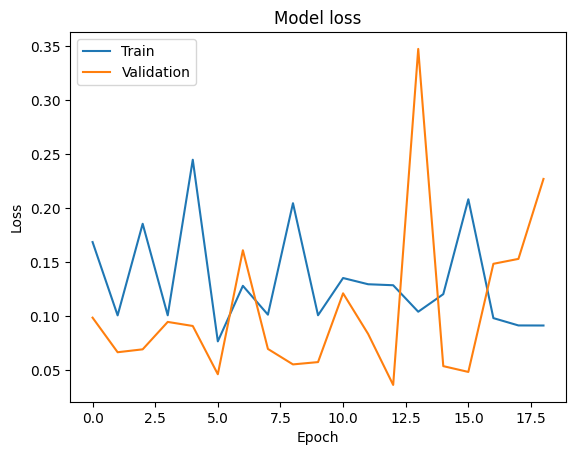

In [85]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()